## Дисперсионный анализ с помощью Python


Мы будем использовать набор данных, собранный `Gapminder Foundation` 

----
Получение данных:
1) Скачать данные можно по ссылке https://github.com/VasilisaS/product_star_mentoring/blob/main/gapminder.csv

2) Для работы с данными их нужно разместить в ту же папку, где лежит исполняемый Python-ноутбук (этот ноутбук, который вы прямо сейчас смотрите)

----


Набор данных `Gapminder` содержит набор переменных, используемых для оценки общего 
состояния здоровья и благополучия населения в странах по всему миру. 

### Исследовательский анализ данных и предварительная обработка

Начнем с загрузки данных и анализа пропущенных значений

In [3]:
# импорт необходимых модулей

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy
from scipy.stats import pearsonr
import pandas as pd
from seaborn import regplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df = pd.read_csv("gapminder.csv") 
df.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.65412162280064,48.673,,0,,6.68438529968262,55.7000007629394,24.04
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.9899469578783,76.918,,9,636.341383366604,7.69932985305786,51.4000015258789,46.72
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.5000733055148,73.131,.42009452521537,2,590.509814347428,4.8487696647644,50.5,65.22
3,Andorra,21943.3398976022,10.17,,,,,,81,,,,,5.36217880249023,,88.92
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.99995388324075,51.093,,-2,172.999227388199,14.5546770095825,75.6999969482422,56.7


In [5]:
#  создадим несколько функций,

# функция проверяет пропущенные значения
def check_missing_values(df, cols): 
    for col in cols: 
        print("Column {} is missing:".format(col)) 
        print((df[col].values == ' ').sum()) 
        print() 
        
# функция ковертирует значения в числовые
def convert_numeric(dataframe, cols): 
    for col in cols: 
        dataframe[col] = pd.to_numeric(dataframe[col], 
                                       errors='coerce') 

In [6]:
print("Пропущенные значения отсутствуют:")
print(df.isnull().values.any())
print()

cols = ['lifeexpectancy', 'breastcancerper100th', 'suicideper100th']
norm_cols = ['internetuserate', 'employrate']

# создаем копию датафрейма с обработанными значениями
df2 = df.copy()

check_missing_values(df, cols)
check_missing_values(df, norm_cols)

convert_numeric(df2, cols)
convert_numeric(df2, norm_cols)

Пропущенные значения отсутствуют:
False

Column lifeexpectancy is missing:
22

Column breastcancerper100th is missing:
40

Column suicideper100th is missing:
22

Column internetuserate is missing:
21

Column employrate is missing:
35



### Я предлагаю вам проанализировать взаимосвязь между:

- уровнем использования Интернета (internetuserate) и уровнем заболеваемости раком (breastcancerper100)


Сделаем отдельные графики для отношения уровней `использования Интернета (internetuserate)` и уровнем `заболеваемости раком (breastcancerper100)` с помощью **Seaborn** и **Matplotlib**.

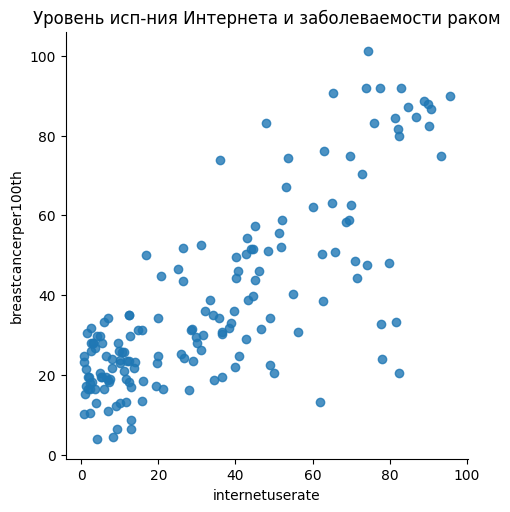

In [8]:
sns.lmplot(x="internetuserate",  # укажите название нужного столбца
           y="breastcancerper100th",  # укажите название нужного столбца
           data=df2, 
           fit_reg=False)
plt.title("Уровень исп-ния Интернета и заболеваемости раком")
plt.show()

## Нулевая гипотеза

График несколько напоминает __Линию__ (прослеживается линейная зависимость, с небольшими выбросами под графиком) 

----

## Формулируем гипотезы

**Нулевая гипотеза** – это гипотеза об отсутствии различий. В данном случае - об отсутсвии взаимосвязи между уровнем использования интернета и уровнем заболевания раком груди.

Это то, что мы хотим опровергнуть. Обозначается как **Но**.


Cоответственно, **альтернативная гипотеза H1** в том, что взаимосвязь между уровнем использования интернета и заболеваемостью раком груди существует

Чтобы проверить гипотезу с помощью  **ANOVA**, нам нужно преобразовать данные

Здесь обе переменные `internetuserate` и `breastcancerper100th` __количественные__, анализ ANOVA подходит для ситуаций, когда __одна переменная является категориальной, а другая – количественной__.

Необходимо преобразование переменной `internetuserate` в категориальную

In [20]:
# функция для разбиения данных на 10 частей

def bin(dataframe, cols):
    for col in cols:
        new_col_name = "{}_bins".format(col)
        dataframe[new_col_name] = pd.qcut(dataframe[col], 
                                          10, 
                                          labels=["1=10%", "2=20%", "3=30%", "4=40%", 
                                                  "5=50%", "6=60%", "7=70%", "8=80", 
                                                  "9=90%", "10=100%"])
        
# создаем копию даатсета и делаем все изменения в копии
df3 = df2.copy()

# применяем функцию разбиения данных на 10 частей
column = ['internetuserate']
bin(df3, column)


In [21]:
# последний столбец - результат разбиения данных по блокам 
df3

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate,internetuserate_bins
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.654122,48.673,,0,,6.684385,55.700001,24.04,2=20%
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.989947,76.918,,9,636.341383366604,7.699330,51.400002,46.72,7=70%
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.500073,73.131,.42009452521537,2,590.509814347428,4.848770,50.500000,65.22,4=40%
3,Andorra,21943.3398976022,10.17,,NaN,,,,81.000000,NaN,,,,5.362179,NaN,88.92,10=100%
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.999954,51.093,,-2,172.999227388199,14.554677,75.699997,56.7,3=30%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Vietnam,722.807558834445,3.91,1.0853671,16.2,1425435000,67.5999984741211,.4,27.851822,75.181,,-7,302.725654656034,11.653322,71.000000,27.84,5=50%
209,West Bank and Gaza,,,5.9360854,NaN,14241333.3333333,11.3000001907349,,36.422772,72.832,,,,NaN,32.000000,71.9,6=60%
210,"Yemen, Rep.",610.3573673206,.2,2.3162346,35.1,234864666.666667,20.2999992370605,,12.349750,65.493,,-2,130.05783139719,6.265789,39.000000,30.64,4=40%
211,Zambia,432.226336974583,3.56,.3413352,13.0,132025666.666667,53.5,13.5,10.124986,49.025,,7,168.623030511023,12.019036,61.000000,35.42,3=30%


После того как переменные были преобразованы и готовы к анализу, можно использовать библиотеку `statsmodel` для выполнения однофакторного __ANOVA__ по выбранным признакам. 

Шаблон для ANOVA: 

`ols("outcome_variable ~ C(independent_variable)", data= data_frame).fit()`

In [22]:
anova_df = df3[['breastcancerper100th', 
    'internetuserate_bins']].dropna()

relate_df = df3[['breastcancerper100th', 
                 'internetuserate_bins']]

anova = smf.ols(formula="breastcancerper100th ~ C(internetuserate_bins)", data=anova_df).fit()

print(anova.summary())

                             OLS Regression Results                             
Dep. Variable:     breastcancerper100th   R-squared:                       0.617
Model:                              OLS   Adj. R-squared:                  0.595
Method:                   Least Squares   F-statistic:                     27.90
Date:                  Mon, 17 Nov 2025   Prob (F-statistic):           2.43e-28
Time:                          12:25:00   Log-Likelihood:                -675.44
No. Observations:                   166   AIC:                             1371.
Df Residuals:                       156   BIC:                             1402.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------